In [1]:
!pip install torch

In [2]:
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')

No GPU found. Training will be carried out on CPU, which might be slower.

If running on Google Colab, you can request a GPU runtime by clicking
`Runtime/Change runtime type` in the top bar menu, then selecting 'GPU'
under 'Hardware accelerator'.


In [3]:
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

In [4]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Conv1D, BatchNormalization
from keras.layers import Activation, MaxPool1D, GlobalAveragePooling1D
from keras.layers import Dense, GaussianDropout, TimeDistributed
from keras.models import Model

import mne
from mne.datasets.sleep_physionet.age import fetch_data

mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
subjects = range(30)
recordings = [1]

In [7]:
# fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')

fnames = [
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011EH-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021EH-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4101E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4101EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4111E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4111EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4121E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4121EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4131E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4131EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4141E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4141EU-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4151E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4151EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4161E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4161EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4171E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4171EU-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4181E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4181EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4191E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4191EP-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4201E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4201EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4211E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4211EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4221E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4221EJ-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4231E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4231EJ-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4241E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4241EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4251E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4251EP-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4261F0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4261FM-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4271F0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4271FC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4281G0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4281GC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4291G0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4291GA-Hypnogram.edf')]

In [8]:
# import pandas as pd
# import mne

# # Step 1: Define your file paths
# fnames = [
#     ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'),
#     # Add more tuples here if needed
# ]

# # Step 2: Load data from the .edf files
# psg_data = mne.io.read_raw_edf(fnames[0][0], preload=True)  # Load PSG data
# hypnogram_data = mne.read_annotations(fnames[0][1])         # Load Hypnogram data

# # Step 3: Convert data to a pandas DataFrame
# psg_df = psg_data.to_data_frame()

# hypnogram_df = pd.DataFrame({
#     'onset': hypnogram_data.onset,
#     'duration': hypnogram_data.duration,
#     'description': hypnogram_data.description
# })


# print("psg_data",psg_data)
# print("hypnogram_data",hypnogram_data)
# print("hypnogram_df",hypnogram_df)



In [9]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True,
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.

    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.

    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()

    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)

    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R']
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)

    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '')
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)

    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

    return raw

In [10]:
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]
print(raws[0])

<RawEDF | SC4001E0-PSG.edf, 2 x 2508001 (25080.0 s), ~7 kB, data not loaded>


In [11]:
# # Print the basic information about the Raw object
# print(raws[0])

# # To get the list of channel names
# print("Channel names:", raws[0].ch_names)

# # To get the data type and shape of the data
# print("Data shape:", raws[0].get_data().shape)

# # To get the data and times for a specific channel
# data, times = raws[0].get_data(picks='eeg', return_times=True)
# print("Data for EEG channels:", data)
# print("Times for EEG data:", times)

# # To get the annotations
# print("Annotations:", raws[0].annotations)

# # To get information about the info attribute, which contains metadata
# print("Info:", raws[0].info)

# # To get the sampling frequency
# print("Sampling frequency:", raws[0].info['sfreq'])

# # To get the duration of the recording
# print("Duration in seconds:", raws[0].n_times / raws[0].info['sfreq'])

# # To get the type of each channel
# print("Channel types:", raws[0].get_channel_types())

# # To get the first few rows of data
# print("First few samples of data:", raws[0].get_data()[:, :10])  # Get first 10 samples for all channels


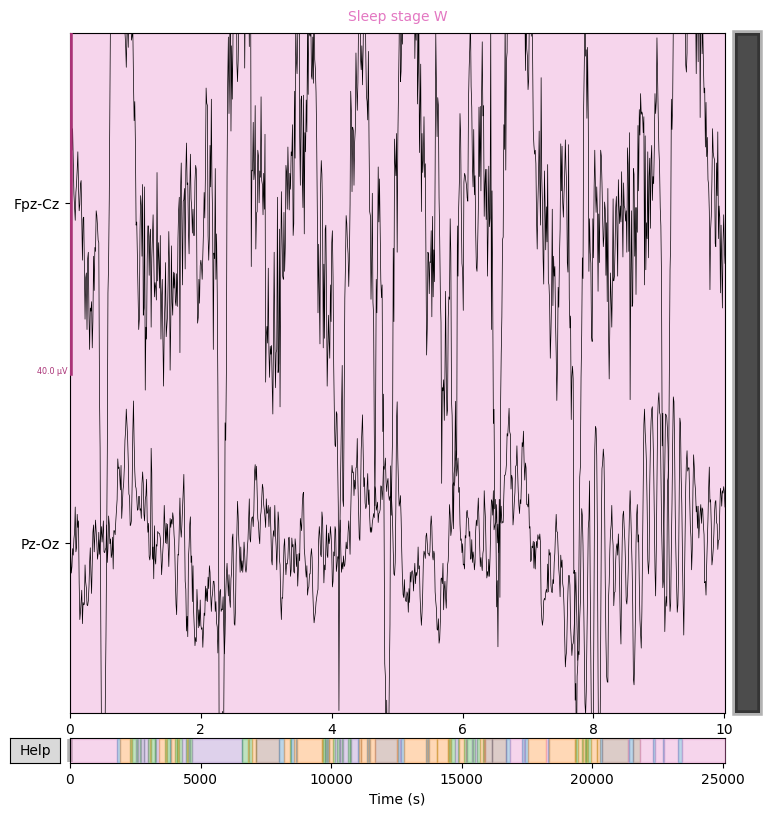

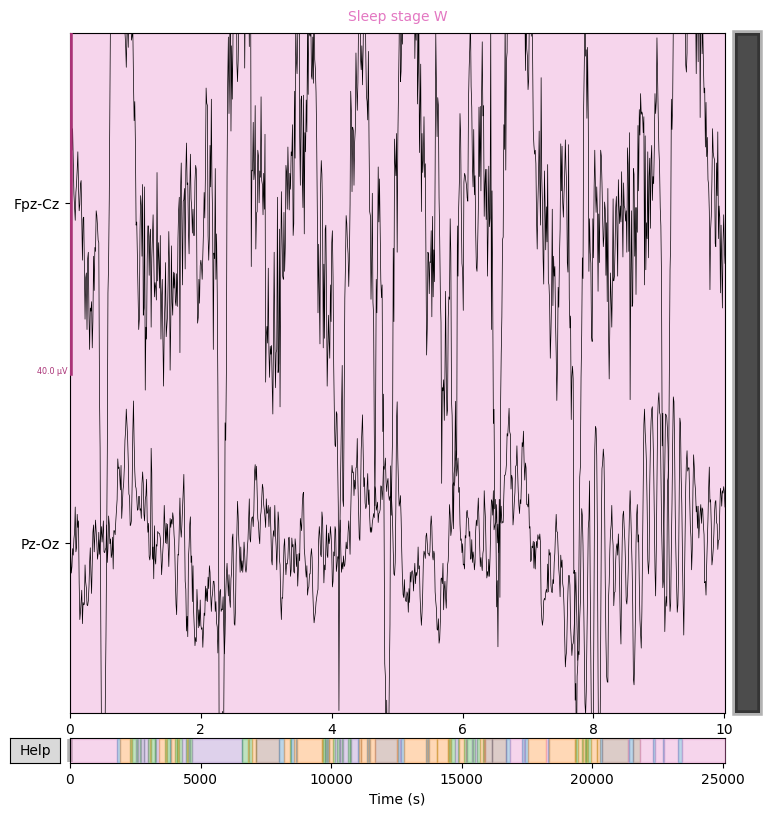

In [12]:
raws[0].plot()

In [13]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)
    print(l_freq, " ",h_freq)

None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30


c:\Users\anshm\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


<RawEDF | SC4001E0-PSG.edf, 2 x 2508001 (25080.0 s), ~38.3 MB, data loaded>


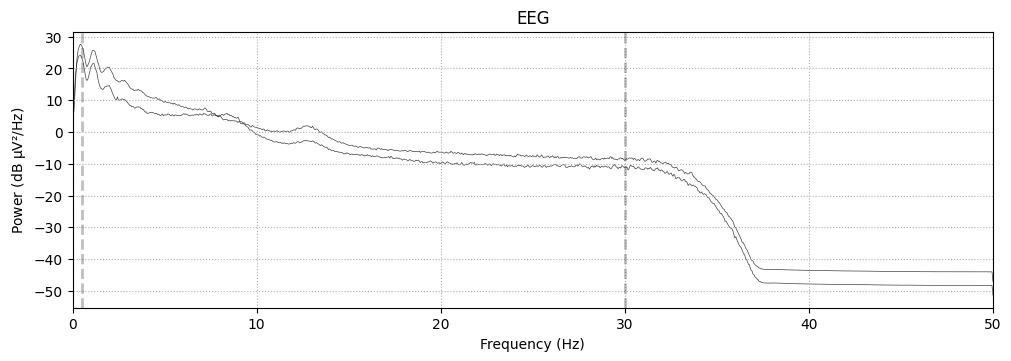

In [14]:
raws[0].plot_psd()
print(raws[0])

In [15]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.

    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.

    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id,
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)

    return epochs.get_data(), epochs.events[:, 2] - 1

In [16]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.

    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None,
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y


def scale(X):
    """Standard scaling of data along the last dimention.

    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.

    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [17]:
# Apply windowing and move to pytorch dataset
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'],
                              rec_nb=raw.info['subject_info']['rec_id'], transform=scale)
                for raw in raws]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

In [18]:
print(dataset)

In [19]:
# # Iterate over the dataset and print each epoch's data and labels
# for i in range(len(dataset)):
#     X, y = dataset[i]
#     print(f"Epoch {i + 1}:\nData: {X}\nLabel: {y}\n")

#     # Break after a certain number of examples to avoid overwhelming output
#     if i >= 10:  # Adjust this number as needed
#         break
# # Iterate over the entire dataset and print the data
# for i, (X, y) in enumerate(dataset):
#     print(f"Epoch {i + 1}:\nData: {X}\nLabel: {y}\n")


In [20]:
# import pandas as pd

# # List to store all event data
# all_events = []

# def extract_epochs(raw, chunk_duration=30.):
#     """Extract non-overlapping epochs from raw data and collect events."""
#     annotation_desc_2_event_id = {
#         'Sleep stage W': 1,
#         'Sleep stage 1': 2,
#         'Sleep stage 2': 3,
#         'Sleep stage 3': 4,
#         'Sleep stage 4': 4,
#         'Sleep stage R': 5}

#     events, _ = mne.events_from_annotations(
#         raw, event_id=annotation_desc_2_event_id,
#         chunk_duration=chunk_duration)
    
#     # Collect event data
#     all_events.append(events)
    
#     # Rest of your existing code
#     event_id = {
#         'Sleep stage W': 1,
#         'Sleep stage 1': 2,
#         'Sleep stage 2': 3,
#         'Sleep stage 3/4': 4,
#         'Sleep stage R': 5}

#     tmax = 30. - 1. / raw.info['sfreq']
#     picks = mne.pick_types(raw.info, eeg=True, eog=True)
#     epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
#                         event_id=event_id, tmin=0., tmax=tmax, baseline=None)

#     return epochs.get_data(), epochs.events[:, 2] - 1


In [21]:
# # Apply windowing and move to PyTorch dataset
# all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'],
#                               rec_nb=raw.info['subject_info']['rec_id'], transform=scale)
#                 for raw in raws]

# # Concatenate into a single dataset
# dataset = ConcatDataset(all_datasets)

# # Flatten the all_events list and convert to a DataFrame
# # flat_events = [event for events in all_events for event in events]
# # df = pd.DataFrame(flat_events, columns=["Time", "Event Type", "Stage"])

# # Save to Excel
# # df.to_excel("events_data.xlsx", index=False)


In [22]:
# print(subj_rec_nbs)

In [23]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):
    """Pick recordings using subject and recording numbers.

    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.
    subj_rec_nbs : list of tuples
        List of pairs (subj_nb, rec_nb) to use in split.

    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from
        `dataset` were picked.
    """
    pick_idx = list()
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)

    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None

    return pick_ds, remaining_ds


def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.

    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.

    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])

    return train_ds, test_ds

In [24]:
torch.manual_seed(87)
np.random.seed(87)

In [25]:
test_recs = [(subj_nb, rec_nb)  # DO NOT CHANGE! This is a fixed set.
             for subj_nb, rec_nb in zip(range(10), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

In [26]:
# Assuming `test_ds` and `train_ds` are of type ConcatDataset

# Function to print a dataset
def print_dataset(dataset, name, num_samples=5):
    print(f"{name} Dataset (showing up to {num_samples} samples):")
    for i in range(min(num_samples, len(dataset))):
        print(f"Sample {i + 1}: {dataset[i]}")

# Print test_ds
print_dataset(test_ds, "Test")

# Print train_ds
print_dataset(train_ds, "Train")

# If you want to print the total number of samples in each dataset
print(f"Total samples in Test Dataset: {len(test_ds)}")
print(f"Total samples in Train Dataset: {len(train_ds)}")


Test Dataset (showing up to 5 samples):
Sample 1: (tensor([[[ 0.3887,  0.9346,  0.8632,  ..., -0.4731, -0.4901, -0.2084],
         [-0.2036, -0.2689, -0.6394,  ...,  0.3970,  0.5562,  0.0466]]],
       dtype=torch.float64), 0)
Sample 2: (tensor([[[-0.3449, -0.5448, -0.2146,  ...,  2.0421,  1.9188,  2.1202],
         [-0.2583, -0.1376, -0.2634,  ...,  0.6086,  1.3655,  0.7621]]],
       dtype=torch.float64), 0)
Sample 3: (tensor([[[ 1.7403,  1.4080,  1.3783,  ...,  1.0748,  1.0731,  0.9778],
         [ 0.4591,  1.5401,  2.3674,  ...,  0.0124, -0.2490, -0.6441]]],
       dtype=torch.float64), 0)
Sample 4: (tensor([[[ 1.0666,  0.9667,  0.8461,  ...,  0.8697,  1.6358,  2.2361],
         [-0.3507,  0.0254,  0.0964,  ...,  0.2286,  0.2047,  0.2401]]],
       dtype=torch.float64), 0)
Sample 5: (tensor([[[ 2.3228,  2.5980,  2.7553,  ...,  0.4782,  0.9377,  1.2709],
         [ 0.4562,  0.2937, -0.2518,  ..., -0.0408,  0.1599,  0.2249]]],
       dtype=torch.float64), 0)
Train Dataset (showing up

In [27]:
# print("test_ds",test_ds)
# print("train_ds",train_ds)

In [28]:
# # To check the contents of test_ds and train_ds
# print("Test Dataset:")
# for ds in test_ds.datasets:
#     print(f"Subject: {ds.subj_nb}, Recording: {ds.rec_nb}")

# print("\nTrain Dataset:")
# if train_ds is not None:
#     for ds in train_ds.datasets:
#         print(f"Subject: {ds.subj_nb}, Recording: {ds.rec_nb}")
# else:
#     print("No remaining datasets.")


In [29]:
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 19569
Validation: 4185
Test: 9850


In [62]:
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split

# # Example Dataset class (replace with your actual dataset)
# class ExampleDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.labels[idx]

# # Example data (replace with your actual data and labels)
# data = np.random.randn(1000, 1, 128, 128).astype(np.float32)
# labels = np.random.randint(0, 5, 1000)

# # Assuming 'subj_nb' is a placeholder for subject numbers (if applicable)
# subject_numbers = np.random.randint(0, 100, 1000)  # Example subject numbers

# # Split the data into training and validation sets
# n_subjects_valid = max(1, int(len(data) * 0.2))
# train_data, valid_data, train_labels, valid_labels = train_test_split(
#     data, labels, test_size=n_subjects_valid, stratify=subject_numbers)

# # Create Dataset instances
# train_ds = ExampleDataset(train_data, train_labels)
# valid_ds = ExampleDataset(valid_data, valid_labels)
# test_ds = ExampleDataset(np.random.randn(200, 1, 128, 128).astype(np.float32), np.random.randint(0, 5, 200))

# # Print the number of examples in each set
# print('Number of examples in each set:')
# print(f'Training: {len(train_ds)}')
# print(f'Validation: {len(valid_ds)}')
# print(f'Test: {len(test_ds)}')

# # Function to print detailed information about the datasets
# def print_dataset_details(dataset, dataset_name):
#     print(f"\n{dataset_name} Dataset Details:")
#     print(f"  Total examples: {len(dataset)}")
#     for i in range(min(2, len(dataset))):  # Only print details for a few examples
#         data, label = dataset[i]
#         print(f"\n  Example {i + 1}:")
#         print(f"    Data shape: {data.shape}")
#         print(f"    Data sample (first few elements): {data.flatten()[:10]}")  # Print first 10 elements
#         print(f"    Label: {label}")

# # Print details for each dataset
# print_dataset_details(train_ds, "Training")
# print_dataset_details(valid_ds, "Validation")
# print_dataset_details(test_ds, "Test")


Number of examples in each set:
Training: 800
Validation: 200
Test: 200

Training Dataset Details:
  Total examples: 800

  Example 1:
    Data shape: (1, 128, 128)
    Data sample (first few elements): [ 0.7407238   0.57161    -1.567815   -1.5964493   0.62899065  1.1103474
 -2.1117713  -0.04716046  0.03442216  0.15910888]
    Label: 0

  Example 2:
    Data shape: (1, 128, 128)
    Data sample (first few elements): [-0.81738806 -0.9485078  -0.43605316 -0.9564548   0.6826537   0.7395598
  0.82321197  1.2322764   0.50506896  1.3734583 ]
    Label: 0

Validation Dataset Details:
  Total examples: 200

  Example 1:
    Data shape: (1, 128, 128)
    Data sample (first few elements): [-0.16437437 -0.8988181  -0.5723571  -0.18747306 -0.2769612   0.20512117
 -0.8794238  -0.6345533  -0.14274696  0.6256972 ]
    Label: 2

  Example 2:
    Data shape: (1, 128, 128)
    Data sample (first few elements): [ 1.7836261  -0.9617927   0.6230304  -0.53995097 -0.4815334  -0.28149673
  1.0908911   0.29266

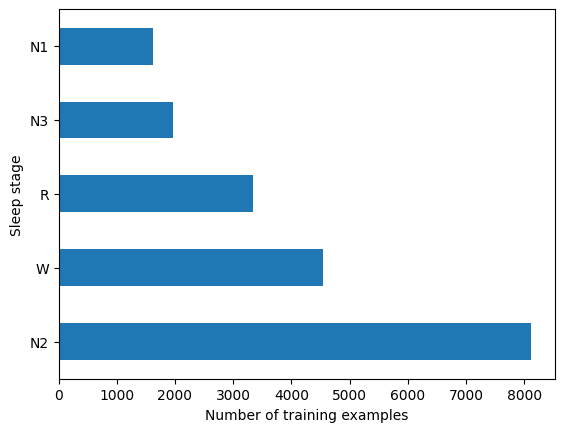

In [30]:
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples');
ax.set_ylabel('Sleep stage');

In [31]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.86283069 2.42190594 0.48241095 1.9877095  1.17355322]


In [32]:
print(class_weights)

[0.86283069 2.42190594 0.48241095 1.9877095  1.17355322]


In [33]:
from torch import nn


class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.

    Convolutional neural network for sleep staging described in [1]_.

    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.

    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.

        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [34]:
model = SleepStagerChambon2018(n_channels=1, sfreq=128, n_classes=5)
print(model)


SleepStagerChambon2018(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=120, out_features=5, bias=True)
  )
)


In [35]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5)

In [36]:
print(model)


SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=320, out_features=5, bias=True)
  )
)


In [37]:
print(sfreq)
print(n_channels)

100.0
2


In [38]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cpu'.


In [39]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 256  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [40]:
for batch in loader_train:
    inputs, labels = batch
    print(input," -----------------",labels)
    # Forward pass, loss computation, backpropagation, etc.


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001781DB5C550>>  ----------------- tensor([2, 0, 2, 0, 2, 2, 0, 0, 4, 3, 1, 3, 3, 1, 3, 4, 2, 3, 4, 2, 2, 1, 2, 2,
        4, 4, 4, 2, 2, 4, 2, 2, 2, 3, 2, 4, 2, 3, 4, 2, 2, 1, 0, 2, 0, 0, 2, 1,
        4, 2, 1, 2, 4, 3, 0, 2, 4, 0, 0, 0, 2, 2, 1, 0, 0, 2, 4, 0, 2, 1, 4, 2,
        0, 0, 2, 4, 2, 4, 0, 2, 2, 4, 4, 1, 3, 2, 4, 1, 3, 1, 0, 3, 0, 2, 0, 2,
        2, 0, 2, 2, 1, 3, 3, 4, 4, 2, 2, 4, 0, 4, 4, 2, 4, 0, 0, 1, 4, 0, 2, 0,
        2, 2, 4, 4, 4, 4, 4, 1], dtype=torch.int32)
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001781DB5C550>>  ----------------- tensor([4, 2, 4, 2, 2, 3, 2, 2, 4, 0, 2, 3, 2, 2, 2, 1, 4, 2, 2, 4, 0, 0, 2, 0,
        1, 2, 0, 0, 2, 3, 4, 2, 2, 2, 2, 3, 0, 1, 0, 4, 0, 0, 3, 2, 4, 0, 0, 4,
        4, 0, 2, 3, 4, 4, 0, 2, 0, 0, 2, 2, 4, 0, 3, 0, 1, 2, 2, 3, 2, 2, 2, 2,
        2, 2, 4, 0, 0, 2, 3, 0, 0, 2, 0, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 4

In [41]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()

    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()

        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(train_loss), perf


def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()

    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()

            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs,
          patience, device, metric=None):
    """Training function.

    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.

    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()

    if metric is None:
        metric = balanced_accuracy_score

    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch,
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})

        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [42]:
# print(f"Epoch {epoch}: Train Loss = {train_loss}, Train Perf = {train_perf}")
# print(f"Epoch {epoch}: Valid Loss = {valid_loss}, Valid Perf = {valid_perf}")

In [43]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [44]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [45]:
print(criterion)

CrossEntropyLoss()


In [46]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cpu'.


In [47]:
n_epochs = 10
patience = 5

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience,
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 1.2471 	 1.0488 	 0.2866 	 0.3380
best val loss inf -> 1.0488
2 	 0.9522 	 0.9806 	 0.4728 	 0.4655
best val loss 1.0488 -> 0.9806
3 	 0.8462 	 0.9650 	 0.5413 	 0.4793
best val loss 0.9806 -> 0.9650
4 	 0.7920 	 0.9097 	 0.5730 	 0.5295
best val loss 0.9650 -> 0.9097
5 	 0.7520 	 0.9063 	 0.6050 	 0.5253
best val loss 0.9097 -> 0.9063
6 	 0.7198 	 0.8402 	 0.6235 	 0.5614
best val loss 0.9063 -> 0.8402
7 	 0.6841 	 0.8802 	 0.6454 	 0.5467
8 	 0.6546 	 0.8355 	 0.6604 	 0.5474
best val loss 0.8402 -> 0.8355
9 	 0.6252 	 0.7934 	 0.6733 	 0.6114
best val loss 0.8355 -> 0.7934
10 	 0.6149 	 0.7723 	 0.6796 	 0.5892
best val loss 0.7934 -> 0.7723


In [48]:
print(best_model)

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=320, out_features=5, bias=True)
  )
)


Text(0, 0.5, "Cohen's kappa")

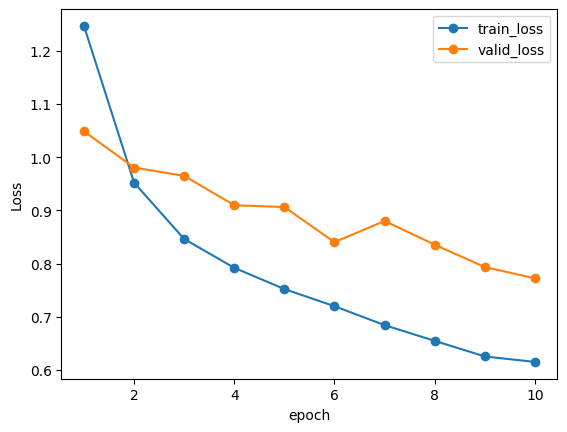

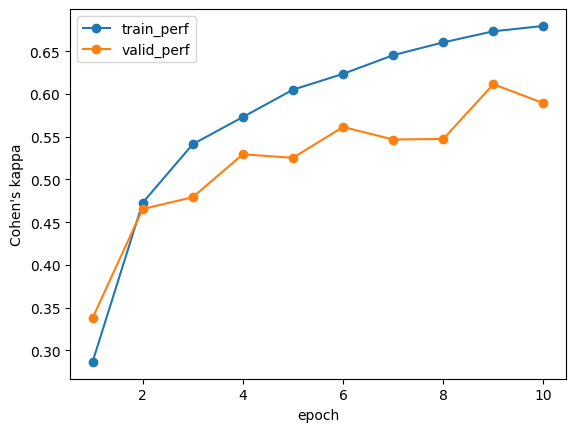

In [49]:
history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
ax2.set_ylabel('Cohen\'s kappa')

In [50]:
history_df

,epoch,train_loss,valid_loss,train_perf,valid_perf
0,1,1.247095,1.048776,0.286636,0.337965
1,2,0.952249,0.980602,0.472793,0.465522
2,3,0.846223,0.965029,0.541299,0.479263
3,4,0.791978,0.909716,0.573029,0.529495
4,5,0.752041,0.906268,0.605023,0.525319
5,6,0.719783,0.840203,0.623512,0.561445
6,7,0.684143,0.880169,0.645388,0.546714
7,8,0.654562,0.835454,0.660366,0.547406
8,9,0.625227,0.793428,0.673296,0.611424
9,10,0.614918,0.772305,0.679593,0.589246


In [51]:
# Compute test performance

best_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())

y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

Test balanced accuracy: 0.753
Test Cohen's kappa: 0.692


In [52]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='# examples')
    fig.tight_layout()

    return fig, ax

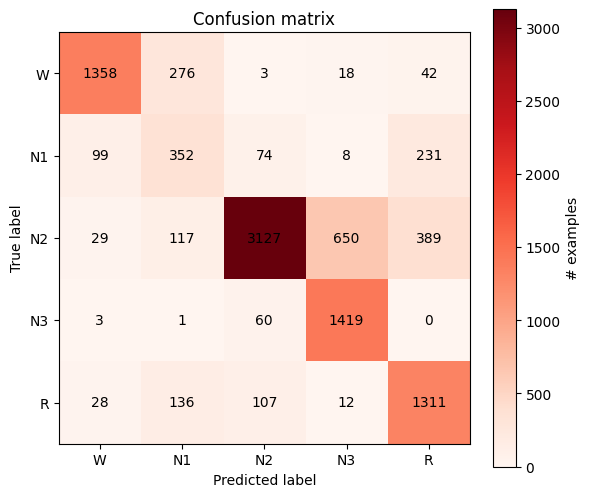

In [53]:
conf_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat, classes_mapping);

In [54]:
conf_mat

array([[1358,  276,    3,   18,   42],
       [  99,  352,   74,    8,  231],
       [  29,  117, 3127,  650,  389],
       [   3,    1,   60, 1419,    0],
       [  28,  136,  107,   12, 1311]], dtype=int64)

In [55]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score

# Assuming you have y_true and y_pred already defined

# Calculate precision, recall, and f1-score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Calculate overall precision and accuracy
overall_precision = precision_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)

# Create a classification report
class_report = classification_report(y_true, y_pred, target_names=classes_mapping.values())

# Print the classification report along with additional metrics
print("Classification Report:\n", class_report)
print("\nAdditional Metrics:")
print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("F1 Score (per class):", f1)
print("Overall Precision (Weighted):", overall_precision)
print("Accuracy:", accuracy)
print("Cohen's Kappa:", kappa)

Classification Report:
               precision    recall  f1-score   support

           W       0.90      0.80      0.85      1697
          N1       0.40      0.46      0.43       764
          N2       0.93      0.73      0.81      4312
          N3       0.67      0.96      0.79      1483
           R       0.66      0.82      0.74      1594

    accuracy                           0.77      9850
   macro avg       0.71      0.75      0.72      9850
weighted avg       0.80      0.77      0.77      9850


Additional Metrics:
Precision (per class): [0.89518787 0.39909297 0.92761792 0.67346939 0.66447035]
Recall (per class): [0.80023571 0.46073298 0.72518553 0.95684423 0.82245922]
F1 Score (per class): [0.84505289 0.42770352 0.81400495 0.79052925 0.73507149]
Overall Precision (Weighted): 0.8001878320929956
Accuracy: 0.7682233502538071
Cohen's Kappa: 0.6918201105599662


In [56]:
# from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score

# # Assuming you have y_true and y_pred already defined

# # Calculate precision, recall, and f1-score for each class
# precision = precision_score(y_true, y_pred, average=None)
# recall = recall_score(y_true, y_pred, average=None)
# f1 = f1_score(y_true, y_pred, average=None)

# # Calculate overall precision and accuracy
# overall_precision = precision_score(y_true, y_pred, average='weighted')
# accuracy = accuracy_score(y_true, y_pred)

# # Calculate Cohen's Kappa
# kappa = cohen_kappa_score(y_true, y_pred)

# # Create a classification report
# class_report = classification_report(y_true, y_pred, target_names=classes_mapping.values())

# # Print the classification report along with additional metrics
# print("Classification Report:\n", class_report)
# print("\nAdditional Metrics:")
# print("Precision (per class):", precision)
# print("Recall (per class):", recall)
# print("F1 Score (per class):", f1)
# print("Overall Precision (Weighted):", overall_precision)
# print("Accuracy:", accuracy)
# print("Cohen's Kappa:", kappa)

Below Needed changes!

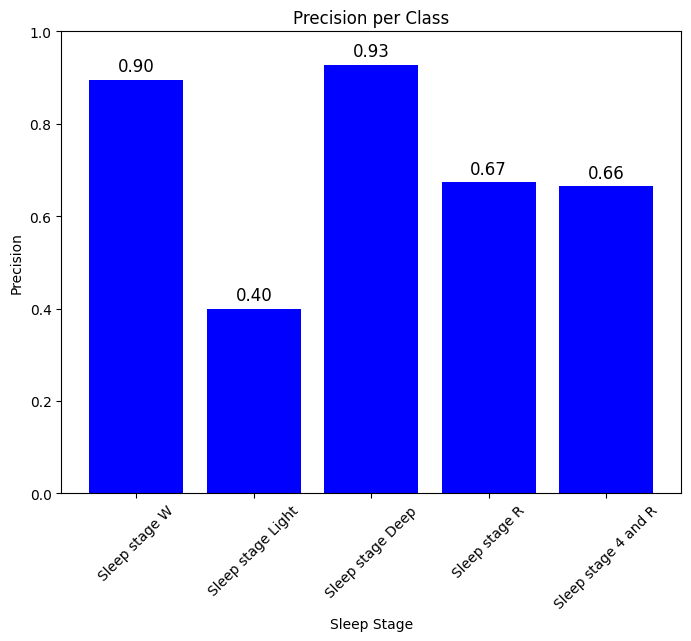

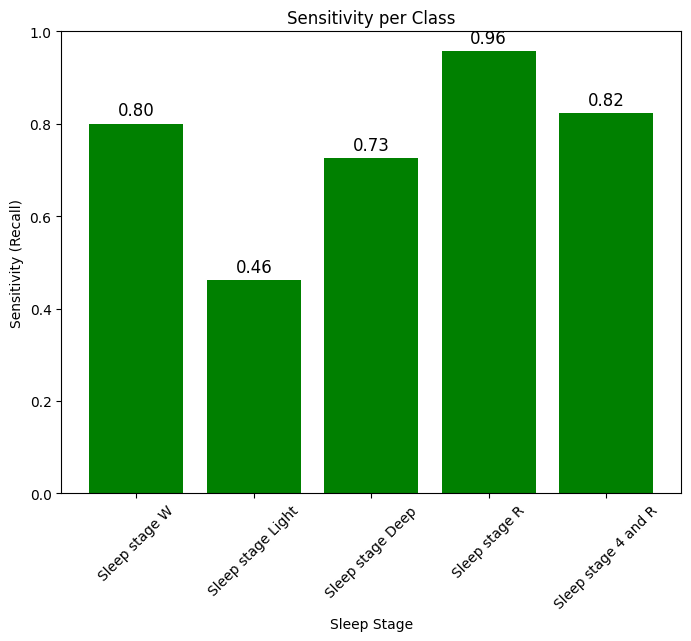

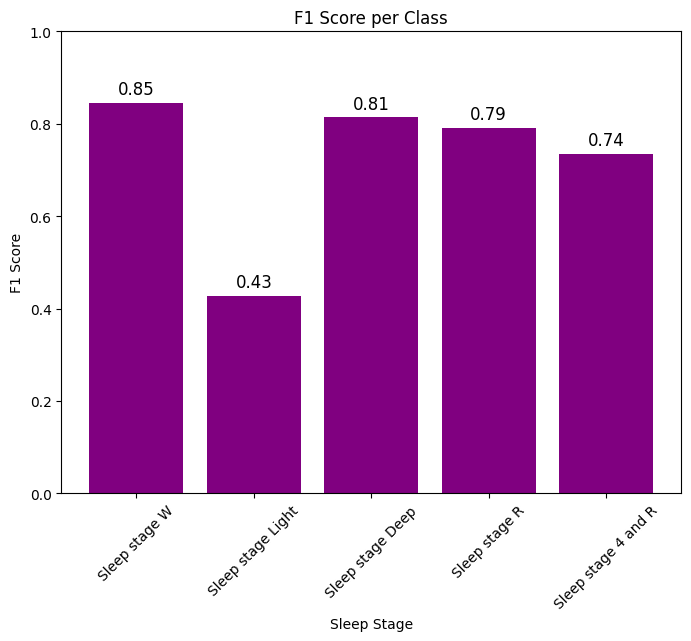

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Replace with your class labels and class indices
class_labels = ['Sleep stage W', 'Sleep stage Light', 'Sleep stage Deep', 'Sleep stage R', 'Sleep stage 4 and R']
class_indices = [0, 1, 2, 3, 4]

# Calculate precision scores for each class separately
precision_per_class = precision_score(y_true, y_pred, labels=class_indices, average=None)

# Create a bar plot for precision per class
plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, precision_per_class, color='blue')
plt.xlabel('Sleep Stage')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.ylim(0, 1.0)  # Set the y-axis limit from 0 to 1 for better visualization

# Add values on top of the bars with two decimal points
for bar, precision in zip(bars, precision_per_class):
    plt.text(bar.get_x() + bar.get_width() / 2, precision + 0.01, f'{precision:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Calculate recall scores (sensitivity) for each class separately
recall_per_class = recall_score(y_true, y_pred, labels=class_indices, average=None)

# Create a bar plot for sensitivity (recall) per class
plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, recall_per_class, color='green')
plt.xlabel('Sleep Stage')
plt.ylabel('Sensitivity (Recall)')
plt.title('Sensitivity per Class')
plt.ylim(0, 1.0)  # Set the y-axis limit from 0 to 1 for better visualization

# Add values on top of the bars with two decimal points
for bar, recall in zip(bars, recall_per_class):
    plt.text(bar.get_x() + bar.get_width() / 2, recall + 0.01, f'{recall:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Calculate F1 scores for each class separately
f1_score_per_class = f1_score(y_true, y_pred, labels=class_indices, average=None)

# Create a bar plot for F1 score per class
plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, f1_score_per_class, color='purple')
plt.xlabel('Sleep Stage')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class')
plt.ylim(0, 1.0)  # Set the y-axis limit from 0 to 1 for better visualization

# Add values on top of the bars with two decimal points
for bar, f1_score in zip(bars, f1_score_per_class):
    plt.text(bar.get_x() + bar.get_width() / 2, f1_score + 0.01, f'{f1_score:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [58]:
print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("F1 Score per class:", f1_score_per_class)


Precision per class: [0.89518787 0.39909297 0.92761792 0.67346939 0.66447035]
Recall per class: [0.80023571 0.46073298 0.72518553 0.95684423 0.82245922]
F1 Score per class: [0.84505289 0.42770352 0.81400495 0.79052925 0.73507149]


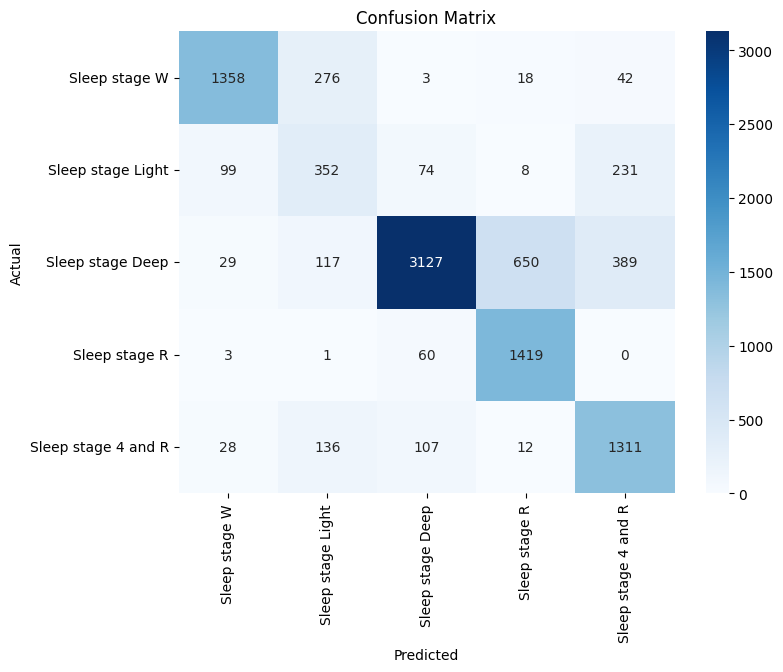

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have y_pred and y_true
confusion_mat = confusion_matrix(y_true, y_pred)

# Define class names
class_names = ['Sleep stage W', 'Sleep stage Light', 'Sleep stage Deep', 'Sleep stage R', 'Sleep stage 4 and R']

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

range(0, 5)


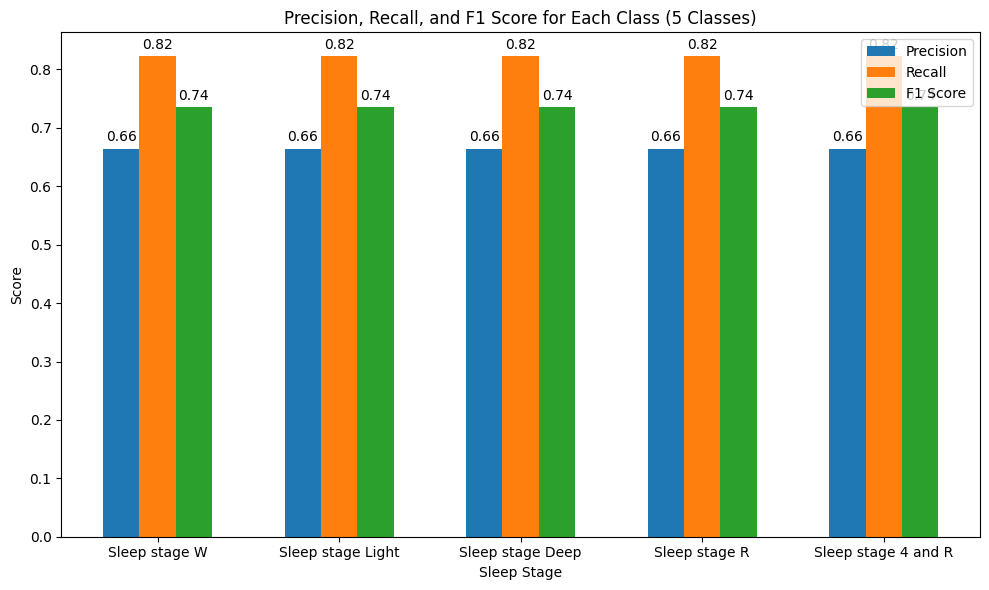

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Define the new 5 class labels
classes = ['Sleep stage W', 'Sleep stage Light', 'Sleep stage Deep', 'Sleep stage R', 'Sleep stage 4 and R']

x = range(len(classes))
print(x)
bar_width = 0.2

precision_bars = plt.bar(x, precision, width=bar_width, label='Precision')
recall_bars = plt.bar([i + bar_width for i in x], recall, width=bar_width, label='Recall')
f1_score_bars = plt.bar([i + 2 * bar_width for i in x], f1_score, width=bar_width, label='F1 Score')

plt.xlabel('Sleep Stage')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score for Each Class (5 Classes)')
plt.xticks([i + bar_width for i in x], classes)
plt.legend()

# Add values on top of the bars
def add_values_on_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_values_on_bars(precision_bars)
add_values_on_bars(recall_bars)
add_values_on_bars(f1_score_bars)

plt.tight_layout()
plt.show()


Below Code Takes 1 hour + Time To Run So Dont Touch Unless Dont Need!

In [61]:
# Define the metric function (e.g., cohen_kappa_score)
from sklearn.metrics import cohen_kappa_score

# Initialize empty lists to store training and validation metrics during training
train_losses, train_perfs, valid_losses, valid_perfs = [], [], [], []

# Training loop
for epoch in range(1, n_epochs + 1):
    train_loss, train_perf = _do_train(
        model, loader_train, optimizer, criterion, device, metric=cohen_kappa_score)
    valid_loss, valid_perf = _validate(
        model, loader_valid, criterion, device, metric=cohen_kappa_score)

    # Append training and validation metrics to lists
    train_losses.append(train_loss)
    train_perfs.append(train_perf)
    valid_losses.append(valid_loss)
    valid_perfs.append(valid_perf)

    # Rest of the code remains the same
    ...

# Plot the training and validation metrics together
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation performance (e.g., Cohen's kappa)
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_perfs, label='Training Performance')
plt.plot(range(1, n_epochs + 1), valid_perfs, label='Validation Performance')
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.legend()
plt.title('Training and Validation Performance')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 